In [80]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split   
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam



# a)

In [81]:
california_data = pickle.load(open('california-housing-dataset.pkl', 'rb')) # Load the data with pickle and readning it as a binary file
x_train, y_train = california_data['x_train'], california_data['y_train']
x_test, y_test = california_data['x_test'], california_data['y_test']


In [82]:
print("Training set dimensions:", x_train.shape, y_train.shape)


Training set dimensions: (15480, 8) (15480,)


In [83]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Sample x_train:", x_train[0])
print("Sample y_train:", y_train[0])


Shape of x_train: (15480, 8)
Shape of y_train: (15480,)
Sample x_train: [ 2.66180000e+00  1.00000000e+01  6.20408163e+00  1.25510204e+00
  1.40300000e+03  2.04518950e+00  3.41000000e+01 -1.16320000e+02]
Sample y_train: 0.81


In [84]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


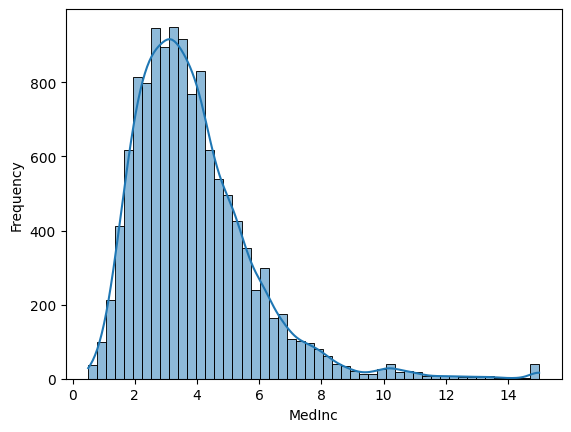

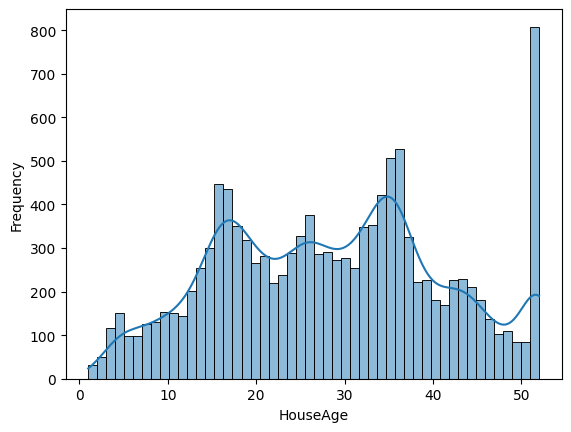

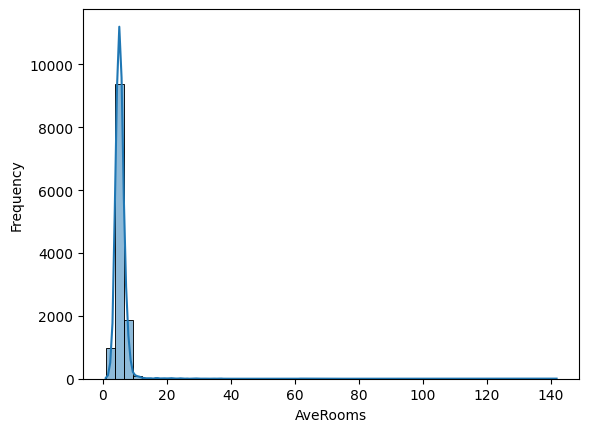

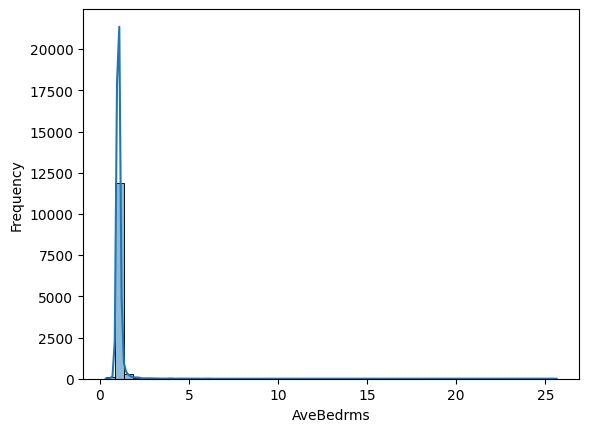

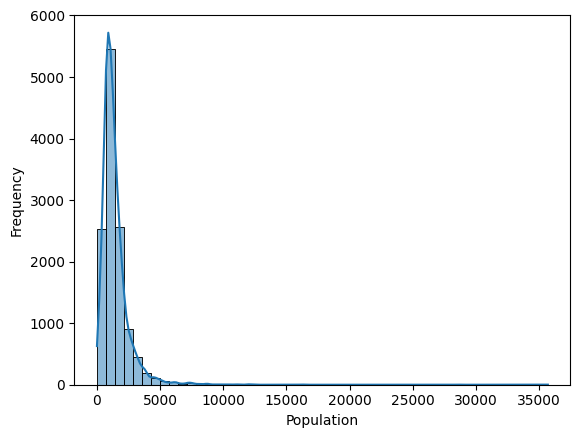

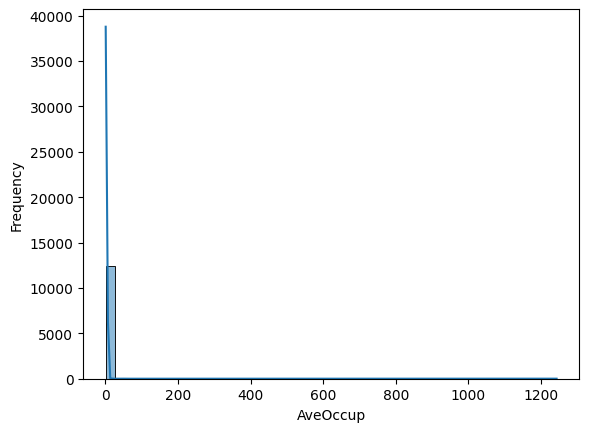

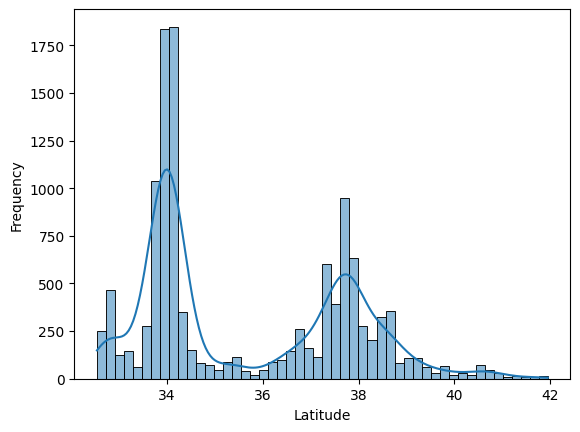

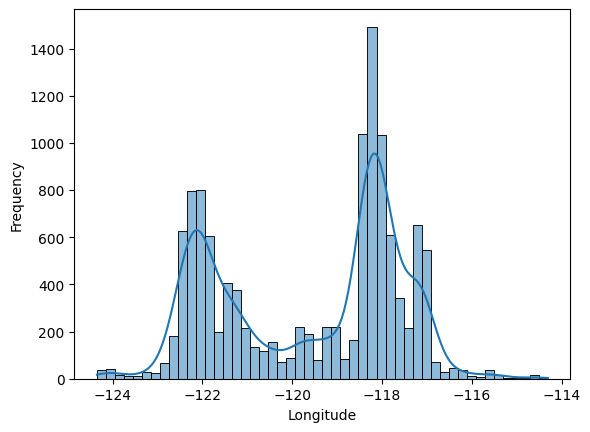

In [85]:
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

for i in range(x_train.shape[1]):
    sns.histplot(x_train[:, i], bins=50, kde=True)
    plt.xlabel(feature_names[i])  # Use the feature name as x-axis label
    plt.ylabel('Frequency')
    plt.show()



In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_normalized = scaler.fit_transform(x_train)
x_val_normalized = scaler.transform(x_val)

print("Sample normalized x_train:", x_train_normalized[0])
print("Sample normalized x_val:", x_val_normalized[0])

Sample normalized x_train: [-0.24641734 -1.63084141  0.10467077 -0.06579177  0.68050224  0.03377491
 -0.59199349  1.11993362]
Sample normalized x_val: [ 0.12303892  0.66191525 -0.06989343 -0.09129668 -0.12244089  0.02285162
 -0.74176514  0.81603931]


# b)

In [91]:
model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(x_train_normalized.shape[1],)),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)  # Output layer for regression task
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

batch_size = 32
epochs = 10

history = model.fit(
    x_train_normalized, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val_normalized, y_val),
    verbose=2
)


Epoch 1/10
387/387 - 2s - loss: 0.9801 - mae: 0.6727 - val_loss: 0.4538 - val_mae: 0.4821 - 2s/epoch - 5ms/step
Epoch 2/10
387/387 - 1s - loss: 0.4697 - mae: 0.4724 - val_loss: 0.4045 - val_mae: 0.4516 - 720ms/epoch - 2ms/step
Epoch 3/10
387/387 - 1s - loss: 0.4221 - mae: 0.4548 - val_loss: 0.3588 - val_mae: 0.4274 - 642ms/epoch - 2ms/step
Epoch 4/10
387/387 - 1s - loss: 0.3927 - mae: 0.4386 - val_loss: 0.3438 - val_mae: 0.4203 - 724ms/epoch - 2ms/step
Epoch 5/10
387/387 - 1s - loss: 0.3664 - mae: 0.4261 - val_loss: 0.3354 - val_mae: 0.4169 - 632ms/epoch - 2ms/step
Epoch 6/10
387/387 - 1s - loss: 0.3623 - mae: 0.4192 - val_loss: 0.3203 - val_mae: 0.4030 - 620ms/epoch - 2ms/step
Epoch 7/10
387/387 - 1s - loss: 0.3472 - mae: 0.4120 - val_loss: 0.3225 - val_mae: 0.4007 - 715ms/epoch - 2ms/step
Epoch 8/10
387/387 - 1s - loss: 0.3421 - mae: 0.4055 - val_loss: 0.3094 - val_mae: 0.3992 - 782ms/epoch - 2ms/step
Epoch 9/10
387/387 - 1s - loss: 0.3294 - mae: 0.3999 - val_loss: 0.3247 - val_mae: 

In [92]:
train_loss, train_mae = model.evaluate(x_train_normalized, y_train, verbose=0)
val_loss, val_mae = model.evaluate(x_val_normalized, y_val, verbose=0)

print(f"Training Set - Loss: {train_loss}, MAE: {train_mae}")
print(f"Validation Set - Loss: {val_loss}, MAE: {val_mae}")


Training Set - Loss: 0.3542933166027069, MAE: 0.39474034309387207
Validation Set - Loss: 0.32579532265663147, MAE: 0.39580774307250977


In [93]:
layers = [
    [64, 32],
    [128, 64, 32],
    [256, 128, 64, 32],  # Adding more layers
    [64, 64, 64],        # More units in each layer
    [128, 128, 64, 32],   # Balanced number of units
    [64, 128, 256, 128, 64],  # Increasing and then decreasing units
]

results = []

for arch in layers:
    model = keras.Sequential([
        keras.layers.Dense(units=units, activation='relu', input_shape=(x_train_normalized.shape[1],))
        for units in arch
    ])
    model.add(keras.layers.Dense(units=1))  # Output layer for regression task

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    history = model.fit(
        x_train_normalized, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val_normalized, y_val),
        verbose=0
    )

    train_loss, _ = model.evaluate(x_train_normalized, y_train, verbose=0)
    val_loss, _ = model.evaluate(x_val_normalized, y_val, verbose=0)

    results.append({'layers': arch, 'train_loss': train_loss, 'val_loss': val_loss})

for result in results:
    print(f"layers: {result['layers']}, Train Loss: {result['train_loss']}, Val Loss: {result['val_loss']}")


layers: [64, 32], Train Loss: 0.3286097049713135, Val Loss: 0.31349143385887146
layers: [128, 64, 32], Train Loss: 0.2941167950630188, Val Loss: 0.29081445932388306
layers: [256, 128, 64, 32], Train Loss: 0.32839879393577576, Val Loss: 0.3237127363681793
layers: [64, 64, 64], Train Loss: 0.2926075756549835, Val Loss: 0.2760491967201233
layers: [128, 128, 64, 32], Train Loss: 0.2742238938808441, Val Loss: 0.2704293727874756
layers: [64, 128, 256, 128, 64], Train Loss: 0.2838495075702667, Val Loss: 0.2917333245277405


In [94]:
results_df = pd.DataFrame(results)
results_df


,layers,train_loss,val_loss
0,"[64, 32]",0.328610,0.313491
1,"[128, 64, 32]",0.294117,0.290814
2,"[256, 128, 64, 32]",0.328399,0.323713
3,"[64, 64, 64]",0.292608,0.276049
4,"[128, 128, 64, 32]",0.274224,0.270429
5,"[64, 128, 256, 128, 64]",0.283850,0.291733


# c)

In [105]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
import pandas as pd

def create_and_compile_model(optimizer):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(x_train_normalized.shape[1],)))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1))  # Output layer for regression task

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

def clipped_momentum_optimizer(learning_rate_schedule):
    optimizer = SGD(learning_rate=learning_rate_schedule, momentum=0.9)

    @tf.function
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss = model.compiled_loss(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        clipped_gradients = [tf.clip_by_norm(grad, 1.0) for grad in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
        return loss

    return optimizer, train_step

optimizers = ['sgd', 'momentum', 'adam']
learning_rates = [0.01, 0.001, 0.0001]

results_optimizers = []

for optimizer_name in optimizers:
    for learning_rate in learning_rates:
        if optimizer_name == 'sgd':
            optimizer = SGD(learning_rate=learning_rate)
            model = create_and_compile_model(optimizer)
        elif optimizer_name == 'momentum':
            # Use learning rate scheduling with clipped gradients for Momentum optimizer
            learning_rate_schedule = ExponentialDecay(
                initial_learning_rate=learning_rate,
                decay_steps=10000,
                decay_rate=0.9,
                staircase=True
            )
            optimizer, train_step = clipped_momentum_optimizer(learning_rate_schedule)
        elif optimizer_name == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
            model = create_and_compile_model(optimizer)

        history = model.fit(
            x_train_normalized, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val_normalized, y_val),
            verbose=0
        )

        train_loss, _ = model.evaluate(x_train_normalized, y_train, verbose=0)
        val_loss, _ = model.evaluate(x_val_normalized, y_val, verbose=0)

        results_optimizers.append({
            'optimizer': optimizer_name,
            'learning_rate': learning_rate,
            'train_loss': train_loss,
            'val_loss': val_loss
        })


In [106]:
results_df_optimizers = pd.DataFrame(results_optimizers)
results_df_optimizers

,optimizer,learning_rate,train_loss,val_loss
0,sgd,0.0100,0.340461,0.321690
1,sgd,0.0010,0.477406,0.472492
2,sgd,0.0001,0.790554,0.753845
3,momentum,0.0100,0.686509,0.655475
4,momentum,0.0010,0.636768,0.609275
5,momentum,0.0001,0.600226,0.576535
6,adam,0.0100,0.311434,0.292168
7,adam,0.0010,0.369031,0.325666
8,adam,0.0001,0.449685,0.441395


# d)

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

final_model = keras.Sequential([
    keras.layers.Dense(units=64, activation='relu', input_shape=(x_train_normalized.shape[1],)),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dense(units=1)  # Output layer for regression task
])

final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

final_epochs = 100  
history_final = final_model.fit(
    x_train_normalized, y_train,
    batch_size=batch_size,
    epochs=final_epochs,
    validation_data=(x_val_normalized, y_val),
    verbose=2
)



Epoch 1/100
387/387 - 2s - loss: 0.9592 - mae: 0.6342 - val_loss: 0.4621 - val_mae: 0.4845 - 2s/epoch - 5ms/step
Epoch 2/100
387/387 - 1s - loss: 0.4428 - mae: 0.4715 - val_loss: 0.6331 - val_mae: 0.4715 - 749ms/epoch - 2ms/step
Epoch 3/100
387/387 - 1s - loss: 0.4087 - mae: 0.4487 - val_loss: 0.4015 - val_mae: 0.4462 - 724ms/epoch - 2ms/step
Epoch 4/100
387/387 - 1s - loss: 0.3882 - mae: 0.4372 - val_loss: 0.3501 - val_mae: 0.4379 - 623ms/epoch - 2ms/step
Epoch 5/100
387/387 - 1s - loss: 0.3655 - mae: 0.4262 - val_loss: 0.3331 - val_mae: 0.4227 - 644ms/epoch - 2ms/step
Epoch 6/100
387/387 - 1s - loss: 0.3519 - mae: 0.4153 - val_loss: 0.3259 - val_mae: 0.4116 - 620ms/epoch - 2ms/step
Epoch 7/100
387/387 - 1s - loss: 0.3484 - mae: 0.4111 - val_loss: 0.5017 - val_mae: 0.4272 - 620ms/epoch - 2ms/step
Epoch 8/100
387/387 - 1s - loss: 0.3714 - mae: 0.4096 - val_loss: 0.3112 - val_mae: 0.3957 - 661ms/epoch - 2ms/step
Epoch 9/100
387/387 - 1s - loss: 0.3437 - mae: 0.4012 - val_loss: 0.3020 - 

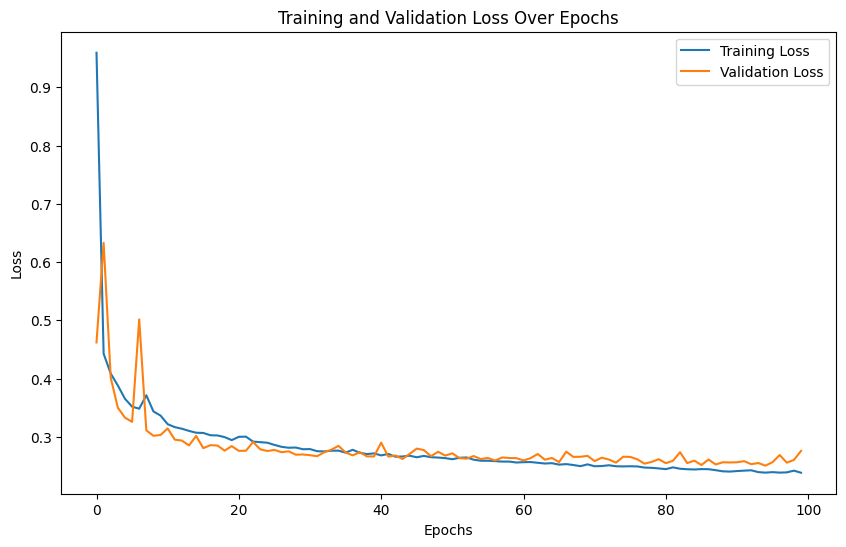

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')  # Use the correct key
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [118]:
# Evaluate the final model on the test set
x_test_normalized = scaler.transform(x_test)
y_pred = final_model.predict(x_test_normalized)
test_loss = mean_squared_error(y_test, y_pred)
print(f"Final Test Error (MSE): {test_loss}")

162/162 [==============================] - 0s 1ms/step
Final Test Error (MSE): 0.28305290140720835


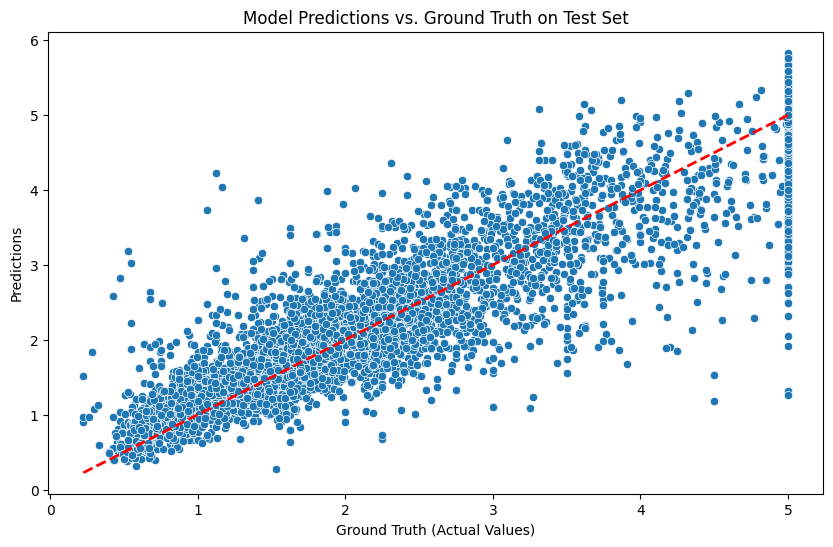

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot comparing model predictions with ground truth values on the test set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test.flatten(), y=y_pred.flatten())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title('Model Predictions vs. Ground Truth on Test Set')
plt.xlabel('Ground Truth (Actual Values)')
plt.ylabel('Predictions')
plt.show()


# e)

=======================


In [ ]:
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Redefine the target variables for binary classification
y_train[y_train < 2] = 0
y_train[y_train >= 2] = 1
y_test[y_test < 2] = 0
y_test[y_test >= 2] = 1

# Define and create your binary classification model
binary_model = create_binary_classification_model(optimizer=keras.optimizers.Adam, learning_rate=0.001)

# Train the binary classification model on the entire training set
binary_history = binary_model.fit(
    x_train_normalized, y_train,
    validation_data=(x_val_normalized, y_val),
    epochs=30, batch_size=32, verbose=1  # Adjust epochs and batch_size as needed
)

# Evaluate the binary classification model on the test set
binary_predictions = binary_model.predict(x_test_normalized)
binary_predictions = (binary_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Report and comment on the performance of the binary classification model
print("Binary Classification Model Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
